In [60]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [234]:
samps, labels = make_blobs(
    n_samples=250, 
    n_features=2, 
    centers=np.array([[-1, 0], [1, 0]]), 
    cluster_std=0.3,
    center_box=(-10.0, 10.0), 
    shuffle=True, 
    random_state=324
)

In [235]:
labels[labels == 0] = -1

In [236]:
labels

array([ 1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1,
        1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1,
        1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,
        1,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,
        1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1,
        1, -1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
        1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1,
        1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,
       -1,  1, -1, -1, -1

In [237]:
F1 = np.s_[:,0]
F2 = np.s_[:,1]

In [238]:
samps_with_ones = np.hstack([samps, np.ones(len(samps)).reshape(len(samps), 1)])

In [239]:
samps_with_ones[:3]

array([[ 0.79442375,  0.08021988,  1.        ],
       [-0.39928129, -0.43023189,  1.        ],
       [-1.01204752, -0.37955748,  1.        ]])

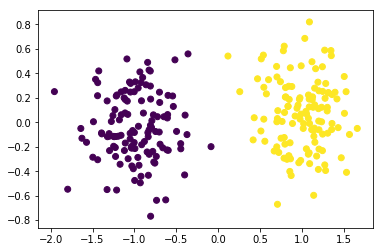

In [240]:
plt.scatter(samps[F1], samps[F2], c=labels)
plt.show()

The discriminant function `step(w.T @ samp_vec)` is:
- Positive when `samp_vec` belongs to class 1 (label 1)
- Negative than zero when `samp_vec` belongs to class 2 (label -1)

In sum, the product between the output of the discriminant function and label is positive for correct classifications. 

In [334]:
class Perceptron:
    
    def __init__(self):
        self.w = np.array([[50.0], [40.0], [23.0]])
        self.w_histories = [self.w.copy()]
        
    @staticmethod
    def step(input):
        if input >= 0: return 1
        elif input < 0: return -1
        
    def linear_combination(self, samp_vec):
        """
        Project of sample vector onto weight vector.
        Orthogonal distance from the decision-boundary hyperplane.
        """
        return float(self.w.T @ samp_vec)
        
    def discriminant(self, samp_vec):
        activation = self.step(self.linear_combination(samp_vec))
        return activation
    
    def increment_weight(self, delta):
        self.w = self.w.copy() + delta
        self.w_histories.append(self.w)
        
    def hyperplane(self, xs, w=None):
        if w is None:
            ys = (- self.w[0]) / self.w[1] * xs - self.w[2] / self.w[1]
        else:
            ys = (- w[0]) / w[1] * xs - w[2]
        return ys
    
    def hyperplane_histories(self, xs, num_recent=3):
        hyperplanes = []
        for w in self.w_histories[-num_recent:-1]:
            hyperplanes.append(self.hyperplane(xs, w))
        return hyperplanes

In [342]:
p = Perceptron()
losses = []

for i in tqdm_notebook(range(100)):
    
    for samp, label in zip(samps_with_ones, labels):
        
        samp_vec = samp.reshape(3, 1)
        
        if p.discriminant(samp_vec) * label < 0:  # misclassified
            
            # multiplying by label is just a compact way to express: 
            # if 
            # p.discriminant(samp_vec) > 0 and label < 0
            # or
            # p.discriminant(samp_vec) < 0 and label > 0
            
            p.increment_weight(samp_vec * label)  # guaranteed to reduce loss on this example
            
            # ========== proof (see 3.69) ==========
            # w_new.T @ samp_vec : together interpreted as the new magnitude of mistake
            #
            # if p.discriminant(samp_vec) > 0 and label < 0:
            #     w_new = w_old - samp_vec
            #     reduces error because:
            #     -> w_new.T @ samp_vec = (w_old - sample_vec).T @ sample_vec
            #     -> = w_old @ sample_vec - sample_vec.T @ sample_vec
            #     -> < w_old @ sample_vec (old magnitude of mistake)
            #
            # elif p.discriminant(samp_vec) < 0 and label > 0:
            #     ... works in a similar way ...
            
            # loss computation only when w is updated
            
            loss = 0.0
    
            for samp, label in zip(samps_with_ones, labels):

                samp_vec = samp.reshape(3, 1)

                if p.discriminant(samp_vec) * label < 0:  # misclassified
                    loss -= p.linear_combination(samp_vec) * label
                    
            losses.append(loss)

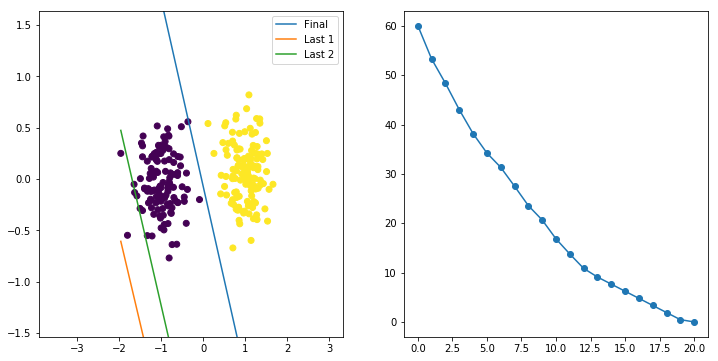

In [343]:
fig = plt.figure(figsize=(12, 6))

fig.add_subplot(121)

plt.scatter(samps[F1], samps[F2], c=labels)

y_lower, y_upper = samps[F2].min(), samps[F2].max()
x_lower, x_upper = samps[F1].min(), samps[F1].max()

xs = np.array([x_lower, x_upper])
ys = p.hyperplane(xs)
plt.plot(xs, ys, label='Final')

for i, hyperplane in enumerate(p.hyperplane_histories(xs)):
    plt.plot(xs, hyperplane, label=f'Last {i+1}')

plt.legend()
    
plt.xlim(x_lower * 2, x_upper * 2)
plt.ylim(y_lower * 2, y_upper * 2)

fig.add_subplot(122)

plt.scatter(np.arange(len(losses)), losses)
plt.plot(losses)

plt.show()

In [344]:
p.w

array([[57.70354838],
       [31.70566557],
       [ 2.        ]])